This requires the IEX_TOKEN environment variable to be set to the IEX API token.

In [23]:
from iexfinance.stocks import Stock, get_historical_data
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [24]:
df_spx = pd.read_csv('sp500_constituents.csv',encoding = "ISO-8859-1",quotechar='"')

In [25]:
df_pricechanges = pd.DataFrame(index=df_spx["Symbol"], 
                               columns=["Symbol", "Security", "GICS_Sector", "GICS_Sub_Industry", 
                                        "latestPrice", "lastweekPrice", "week52High", 
                                        "pct_change1D", "pct_change1W", "pct_changeFrom1YHigh"])


In [26]:
def retrieve_new_data():
    lastweek_date = datetime.today() - timedelta(days=7) - timedelta(days=max(datetime.today().weekday() - 4, 0))
    
    print("Today:",datetime.today(),", Last week:",lastweek_date)

    for i in range(len(df_spx)):
        print("Retrieving " + df_spx["Symbol"][i] + "    ", end="\r", flush=True)
        df_pricechanges["Symbol"][i] = df_spx["Symbol"][i]
        df_pricechanges["Security"][i] = df_spx["Security"][i]
        df_pricechanges["GICS_Sector"][i] = df_spx["GICS_Sector"][i]
        df_pricechanges["GICS_Sub_Industry"][i] = df_spx["GICS_Sub_Industry"][i]

        quote = Stock(df_spx["Symbol"][i], output_format="json").get_quote()
        df_pricechanges["latestPrice"][i] = quote["latestPrice"]
        df_pricechanges["week52High"][i] = quote["week52High"]
        df_pricechanges["pct_change1D"][i] = quote["changePercent"]
        df_pricechanges["pct_changeFrom1YHigh"][i] = quote["latestPrice"] / quote["week52High"] - 1

        historical_data = get_historical_data(df_spx["Symbol"][i], start=lastweek_date.strftime("%Y%m%d"), close_only=True)
        df_pricechanges["lastweekPrice"][i] = historical_data[lastweek_date.strftime("%Y-%m-%d")]["close"]
        df_pricechanges["pct_change1W"][i] = quote["latestPrice"]/ df_pricechanges["lastweekPrice"][i]  - 1

In [27]:
def make_charts(data, value, title):
    data_subset = data[data.GICS_Sector.isin(["Communication Services", 
                                                               "Information Technology", 
                                                               "Consumer Staples", "Financials"])]
    if value == "pct_changeFrom1YHigh":
        hlines = [-0.25,-0.4, -0.5]
    else:
        hlines = [-0.05,-0.1]
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.title(title + " drop")
    plt.scatter('Symbol', value, c=data.head(10).GICS_Sector.cat.codes, s=300, cmap='Set1', data=data.head(10))
    plt.hlines(hlines, xmin=-1, xmax=10, linestyles='dotted')
    plt.xlabel('Ticker')
    plt.ylabel('Change in price')

    plt.subplot(1,2,2)
    plt.title(title + " drop in tech, consumer staples, financials")
    plt.scatter('Symbol', value, c=data_subset.head(10).GICS_Sector.cat.codes, cmap='Set1', s=300, data=data_subset.head(10))
    plt.hlines(hlines, xmin=-1, xmax=10, linestyles='dotted')
    plt.xlabel('Ticker')
    plt.ylabel('Change in price')
    plt.show()

Choose whether to read an existing file or run the latest data from IEX

In [28]:
### Run latest data from IEX
retrieve_new_data()
df_pricechanges.head()
df_pricechanges.to_csv("results/pricechanges_" + datetime.today().strftime("%Y-%m-%d") + ".csv")
df_pricechanges.GICS_Sector = pd.Categorical(df_pricechanges.GICS_Sector)

Today: 2020-02-15 14:42:04.659800 , Last week: 2020-02-07 14:42:04.659800


In [29]:
### Read existing file
#df_pricechanges = pd.read_csv('results/pricechanges_2020-02-07.csv',encoding = "ISO-8859-1",quotechar='"')
#df_pricechanges.GICS_Sector = pd.Categorical(df_pricechanges.GICS_Sector)

Largest drops in the day

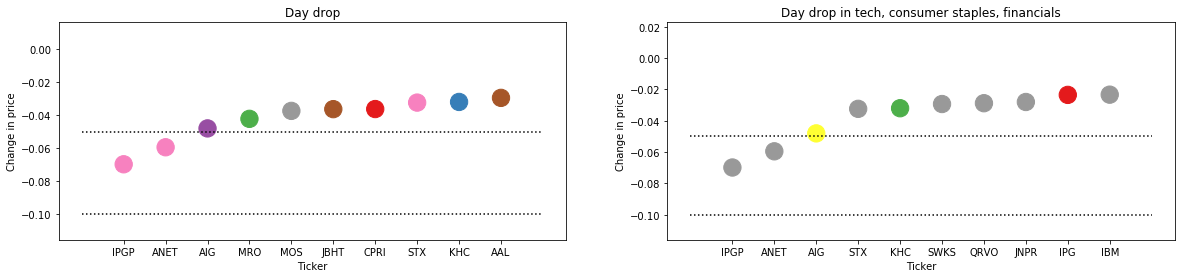

,Symbol,Security,GICS_Sector,GICS_Sub_Industry,latestPrice,pct_change1D
Symbol,,,,,,
IPGP,IPGP,IPG Photonics Corp.,Information Technology,Electronic Manufacturing Services,139.49,-0.06988
ANET,ANET,Arista Networks,Information Technology,Communications Equipment,223.47,-0.05955
AIG,AIG,American International Group,Financials,Property & Casualty Insurance,48.48,-0.04811
MRO,MRO,Marathon Oil Corp.,Energy,Oil & Gas Exploration & Production,10.64,-0.0423
MOS,MOS,The Mosaic Company,Materials,Fertilizers & Agricultural Chemicals,18.75,-0.03747
JBHT,JBHT,J. B. Hunt Transport Services,Industrials,Trucking,110.07,-0.03642
CPRI,CPRI,Capri Holdings,Consumer Discretionary,"Apparel, Accessories & Luxury Goods",28.62,-0.03636
STX,STX,Seagate Technology,Information Technology,"Technology Hardware, Storage & Peripherals",53.99,-0.03244
KHC,KHC,Kraft Heinz Co,Consumer Staples,Packaged Foods & Meats,26.88,-0.03205


In [30]:
day_drop = df_pricechanges.sort_values(by=['pct_change1D'])[["Symbol", "Security", "GICS_Sector", 
                                                        "GICS_Sub_Industry", "latestPrice", "pct_change1D"]]
make_charts(day_drop, "pct_change1D", "Day")
day_drop.head(20)

Largest drops from 1 week

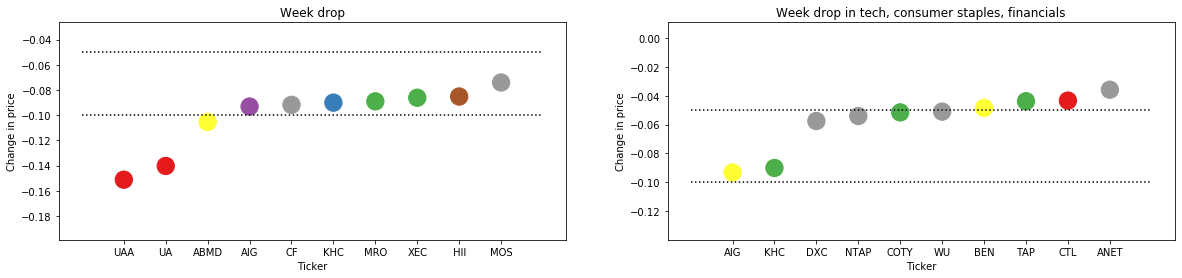

,Symbol,Security,GICS_Sector,GICS_Sub_Industry,latestPrice,lastweekPrice,pct_change1W
Symbol,,,,,,,
UAA,UAA,Under Armour Class A,Consumer Discretionary,"Apparel, Accessories & Luxury Goods",17.19,20.25,-0.151111
UA,UA,Under Armour Class C,Consumer Discretionary,"Apparel, Accessories & Luxury Goods",15.45,17.97,-0.140234
ABMD,ABMD,ABIOMED Inc,Health Care,Health Care Equipment,167.22,186.91,-0.105345
AIG,AIG,American International Group,Financials,Property & Casualty Insurance,48.48,53.46,-0.0931538
CF,CF,CF Industries Holdings Inc,Materials,Fertilizers & Agricultural Chemicals,38.3,42.17,-0.0917714
KHC,KHC,Kraft Heinz Co,Consumer Staples,Packaged Foods & Meats,26.88,29.54,-0.0900474
MRO,MRO,Marathon Oil Corp.,Energy,Oil & Gas Exploration & Production,10.64,11.68,-0.0890411
XEC,XEC,Cimarex Energy,Energy,Oil & Gas Exploration & Production,39.35,43.06,-0.0861588
HII,HII,Huntington Ingalls Industries,Industrials,Aerospace & Defense,246.21,269.14,-0.0851973


In [31]:
week_drop = df_pricechanges.sort_values(by=['pct_change1W'])[["Symbol", "Security", "GICS_Sector", 
                                                        "GICS_Sub_Industry", "latestPrice","lastweekPrice", "pct_change1W"]]
make_charts(week_drop, "pct_change1W", "Week")
week_drop.head(20)

Largest drops from 1 year high

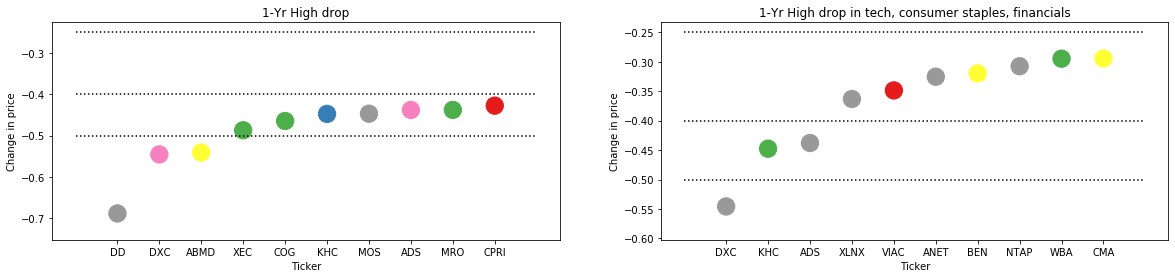

,Symbol,Security,GICS_Sector,GICS_Sub_Industry,latestPrice,week52High,pct_changeFrom1YHigh
Symbol,,,,,,,
DD,DD,DuPont de Nemours Inc,Materials,Specialty Chemicals,53.1,170.46,-0.68849
DXC,DXC,DXC Technology,Information Technology,IT Consulting & Other Services,30.82,67.83,-0.545629
ABMD,ABMD,ABIOMED Inc,Health Care,Health Care Equipment,167.22,364.31,-0.540995
XEC,XEC,Cimarex Energy,Energy,Oil & Gas Exploration & Production,39.35,76.74,-0.48723
COG,COG,Cabot Oil & Gas,Energy,Oil & Gas Exploration & Production,14.8,27.65,-0.464738
KHC,KHC,Kraft Heinz Co,Consumer Staples,Packaged Foods & Meats,26.88,48.66,-0.447596
MOS,MOS,The Mosaic Company,Materials,Fertilizers & Agricultural Chemicals,18.75,33.91,-0.447066
ADS,ADS,Alliance Data Systems,Information Technology,Data Processing & Outsourced Services,102.83,182.95,-0.437934
MRO,MRO,Marathon Oil Corp.,Energy,Oil & Gas Exploration & Production,10.64,18.93,-0.437929


In [32]:
yearhigh_drop = df_pricechanges.sort_values(by=['pct_changeFrom1YHigh'])[["Symbol", "Security", "GICS_Sector", 
                                            "GICS_Sub_Industry", "latestPrice", "week52High","pct_changeFrom1YHigh"]]
make_charts(yearhigh_drop, "pct_changeFrom1YHigh", "1-Yr High")
yearhigh_drop.head(40)